In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


# Modelo BERT para multietiqueta

# Entrenamiento del modelo

**epochs = 5**

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5 - Loss: 0.4883
Epoch 2/5 - Loss: 0.4103
Epoch 3/5 - Loss: 0.4028
Epoch 4/5 - Loss: 0.3963
Epoch 5/5 - Loss: 0.3832


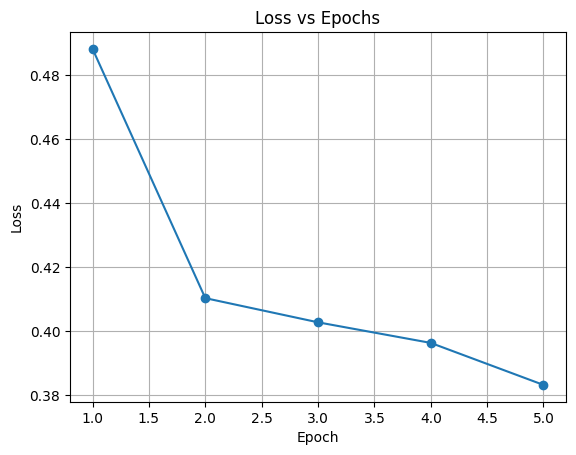

Classification Report - Validación
              precision    recall  f1-score   support

 Adventurous       0.00      0.00      0.00        41
       Angry       0.00      0.00      0.00        24
     Excited       0.00      0.00      0.00        37
       Funny       0.00      0.00      0.00         6
       Happy       0.47      0.84      0.60        75
Heartwarming       0.00      0.00      0.00        11
     Hopeful       0.00      0.00      0.00        19
   Inspiring       0.35      0.80      0.48        59
   Nostalgic       0.00      0.00      0.00        20
    Romantic       0.00      0.00      0.00        26
         Sad       0.40      0.60      0.48        52
      Scared       0.00      0.00      0.00         6
 Suspenseful       0.75      0.12      0.21        24

   micro avg       0.41      0.36      0.38       400
   macro avg       0.15      0.18      0.14       400
weighted avg       0.24      0.36      0.26       400
 samples avg       0.42      0.36      0.37  

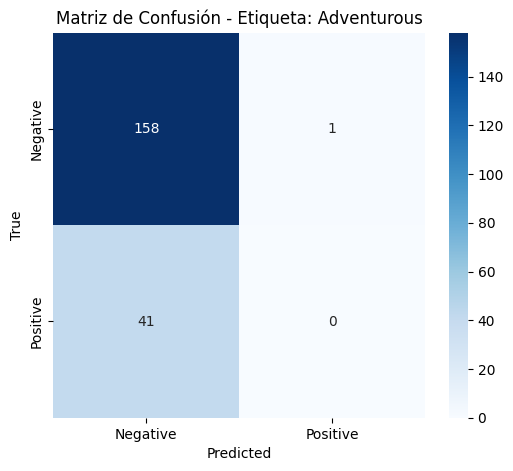

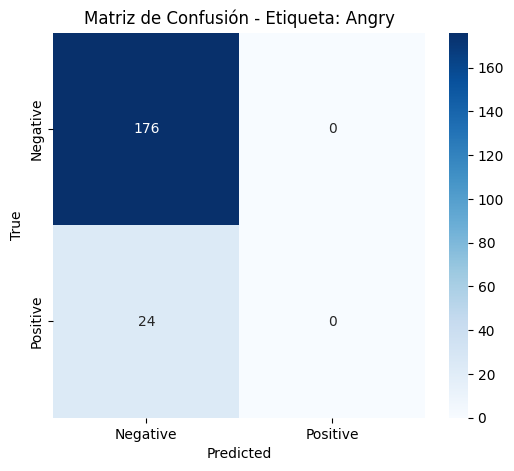

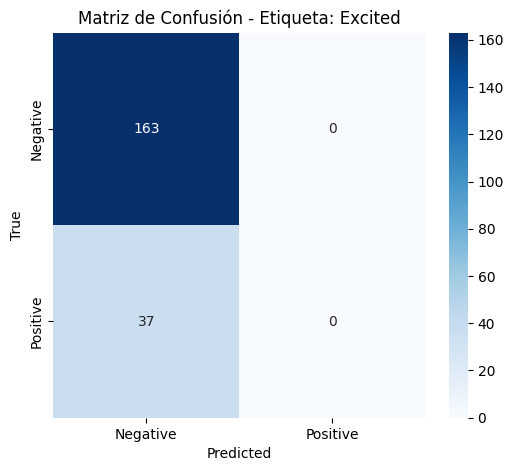

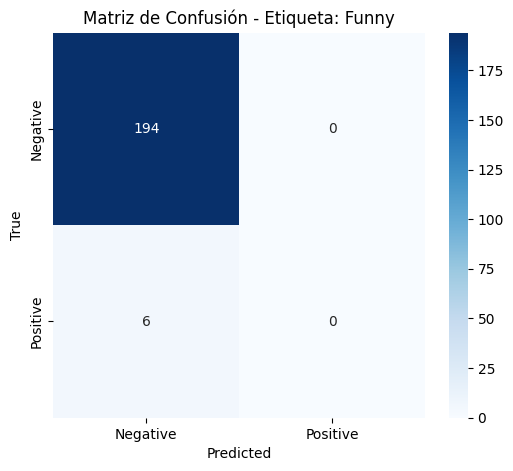

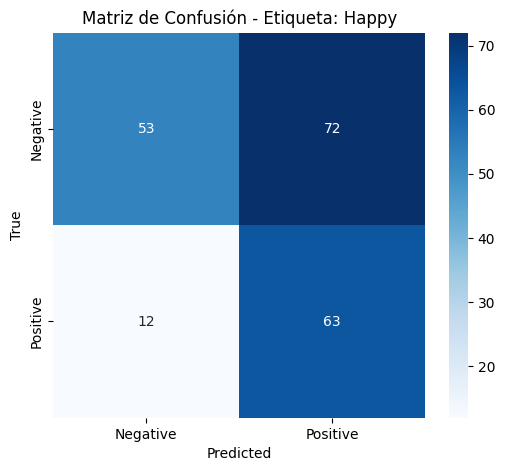

Generando Reporte de Métricas Personalizado...
        Etiqueta  Precisión    Recall  F1-Score ROC-AUC
0    Adventurous   0.000000  0.000000  0.000000    None
1          Angry   0.000000  0.000000  0.000000    None
2        Excited   0.000000  0.000000  0.000000    None
3          Funny   0.000000  0.000000  0.000000    None
4          Happy   0.466667  0.840000  0.600000    None
5   Heartwarming   0.000000  0.000000  0.000000    None
6        Hopeful   0.000000  0.000000  0.000000    None
7      Inspiring   0.345588  0.796610  0.482051    None
8      Nostalgic   0.000000  0.000000  0.000000    None
9       Romantic   0.000000  0.000000  0.000000    None
10           Sad   0.397436  0.596154  0.476923    None
11        Scared   0.000000  0.000000  0.000000    None
12   Suspenseful   0.750000  0.125000  0.214286    None
Reporte de métricas guardado como 'metrics_report.csv'.
Dataset completo con predicciones guardado como 'complete_music_predictions.csv'.


In [ ]:
# Importar librerías necesarias
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Leer la muestra y el dataset completo
df_sample = pd.read_csv('sample_music_ready_for_bert.csv')
df_complete = pd.read_csv('music_ready_for_bert.csv')

# Configuración del tokenizador
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
max_len = 128

# Tokenizar la columna 'bert_input' de la muestra
encodings = tokenizer(
    df_sample['bert_input'].tolist(),
    max_length=max_len,
    padding="max_length",
    truncation=True,
    return_tensors="pt"
)

# Crear tensores para entradas y máscaras de atención
input_ids, attention_mask = encodings["input_ids"], encodings["attention_mask"]

# Binarizar las emociones (columna 'emotion')
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(df_sample['emotion'].str.split(", "))
labels_tensor = torch.tensor(labels, dtype=torch.float32)

# Dividir datos en conjuntos de entrenamiento y validación
train_inputs, val_inputs, train_masks, val_masks, train_labels, val_labels = train_test_split(
    input_ids, attention_mask, labels_tensor, test_size=0.2, random_state=42
)

# Crear DataLoaders para manejar los datos por lotes
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_dataloader = DataLoader(val_data, batch_size=batch_size)

# Modelo BERT para clasificación multietiqueta
class BertForMultilabelClassification(torch.nn.Module):
    def __init__(self, num_labels):
        super(BertForMultilabelClassification, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return torch.sigmoid(outputs.logits)

model = BertForMultilabelClassification(num_labels=len(mlb.classes_))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Configuración del optimizador y función de pérdida
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.BCELoss()

# Lista para guardar la pérdida por época
loss_values = []

# Entrenamiento del modelo
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        input_ids, masks, labels = [b.to(device) for b in batch]

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=masks)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    loss_values.append(avg_loss)
    print(f"Epoch {epoch + 1}/{epochs} - Loss: {avg_loss:.4f}")

# Gráfica de la función de pérdida
plt.plot(range(1, epochs + 1), loss_values, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.grid()
plt.show()

# Validación del modelo en el conjunto de validación
model.eval()
all_preds_val = []
all_labels_val = []

with torch.no_grad():
    for batch in val_dataloader:
        input_ids, masks, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=masks)
        preds = (outputs > 0.3).int()  # Umbral de 0.3
        all_preds_val.append(preds.cpu())
        all_labels_val.append(labels.cpu())

# Concatenar resultados de validación
all_preds_val = torch.cat(all_preds_val)
all_labels_val = torch.cat(all_labels_val)

# Classification report en el conjunto de validación
print("Classification Report - Validación")
print(classification_report(all_labels_val, all_preds_val, target_names=mlb.classes_, zero_division=0))

# Tokenizar el dataset completo
encodings_complete = tokenizer(
    df_complete['bert_input'].tolist(),
    max_length=max_len,
    padding="max_length",
    truncation=True,
    return_tensors="pt"
)

# Crear DataLoader para predicción en el dataset completo
input_ids_complete = encodings_complete["input_ids"]
attention_mask_complete = encodings_complete["attention_mask"]
complete_data = TensorDataset(input_ids_complete, attention_mask_complete)
complete_dataloader = DataLoader(complete_data, batch_size=8)

# Realizar predicciones en el dataset completo
all_predictions = []
with torch.no_grad():
    for batch in complete_dataloader:
        input_ids_batch, attention_mask_batch = [b.to(device) for b in batch]
        outputs = model(input_ids_batch, attention_mask=attention_mask_batch)
        predictions = (outputs > 0.3).int()  # Umbral reducido a 0.3
        all_predictions.append(predictions.cpu())

# Concatenar todas las predicciones
all_predictions = torch.cat(all_predictions)

# Convertir predicciones a etiquetas
predicted_emotions = [
    [mlb.classes_[i] for i, val in enumerate(pred) if val == 1]
    for pred in all_predictions.numpy()
]

# Agregar predicciones al DataFrame completo
df_complete['predicted_emotions'] = ["; ".join(emotions) for emotions in predicted_emotions]

# **Matriz de Confusión Multietiqueta**
print("Generando Matriz de Confusión Multietiqueta...")
confusion_matrices = multilabel_confusion_matrix(all_labels_val.numpy(), all_preds_val.numpy())
for i, matrix in enumerate(confusion_matrices[:5]):  # Cambia el rango según necesidad
    plt.figure(figsize=(6, 5))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f'Matriz de Confusión - Etiqueta: {mlb.classes_[i]}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# **Reporte de Métricas Personalizado**
print("Generando Reporte de Métricas Personalizado...")
metrics = []
for i, label in enumerate(mlb.classes_):
    precision = precision_score(all_labels_val.numpy()[:, i], all_preds_val.numpy()[:, i], zero_division=0)
    recall = recall_score(all_labels_val.numpy()[:, i], all_preds_val.numpy()[:, i], zero_division=0)
    f1 = f1_score(all_labels_val.numpy()[:, i], all_preds_val.numpy()[:, i], zero_division=0)
    try:
        auc = roc_auc_score(all_labels_val.numpy()[:, i], all_predictions.numpy()[:, i])
    except ValueError:
        auc = None
    metrics.append((label, precision, recall, f1, auc))

# Crear DataFrame para visualizar las métricas
df_metrics = pd.DataFrame(metrics, columns=["Etiqueta", "Precisión", "Recall", "F1-Score", "ROC-AUC"])
print(df_metrics)

# Guardar el reporte en un archivo CSV
df_metrics.to_csv('metrics_report5.csv', index=False)
print("Reporte de métricas guardado como 'metrics_report.csv'.")

# Guardar el dataset completo con las predicciones
df_complete.to_csv('complete_music_predictions5.csv', index=False)
print("Dataset completo con predicciones guardado como 'complete_music_predictions.csv'.")



**epochs = 15**

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15 - Loss: 0.5046
Epoch 2/15 - Loss: 0.4096
Epoch 3/15 - Loss: 0.4004
Epoch 4/15 - Loss: 0.3906
Epoch 5/15 - Loss: 0.3759
Epoch 6/15 - Loss: 0.3520
Epoch 7/15 - Loss: 0.3269
Epoch 8/15 - Loss: 0.2978
Epoch 9/15 - Loss: 0.2702
Epoch 10/15 - Loss: 0.2460
Epoch 11/15 - Loss: 0.2263
Epoch 12/15 - Loss: 0.2044
Epoch 13/15 - Loss: 0.1859
Epoch 14/15 - Loss: 0.1686
Epoch 15/15 - Loss: 0.1538


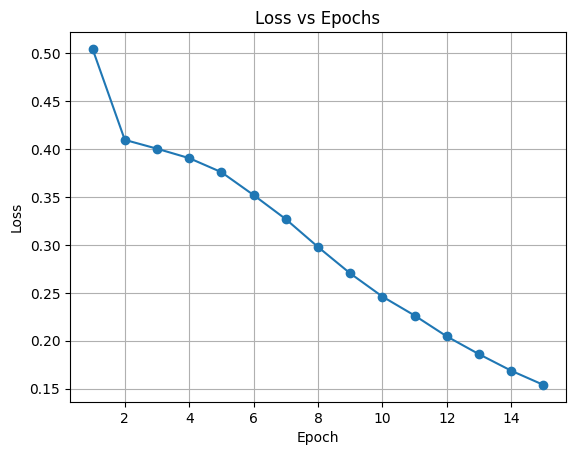

Classification Report - Validación
              precision    recall  f1-score   support

 Adventurous       0.37      0.39      0.38        41
       Angry       0.38      0.21      0.27        24
     Excited       0.12      0.08      0.10        37
       Funny       0.00      0.00      0.00         6
       Happy       0.62      0.44      0.52        75
Heartwarming       0.50      0.09      0.15        11
     Hopeful       0.00      0.00      0.00        19
   Inspiring       0.40      0.64      0.50        59
   Nostalgic       0.27      0.35      0.30        20
    Romantic       0.40      0.46      0.43        26
         Sad       0.39      0.67      0.49        52
      Scared       0.50      0.17      0.25         6
 Suspenseful       0.34      0.46      0.39        24

   micro avg       0.39      0.41      0.40       400
   macro avg       0.33      0.30      0.29       400
weighted avg       0.38      0.41      0.37       400
 samples avg       0.40      0.41      0.39  

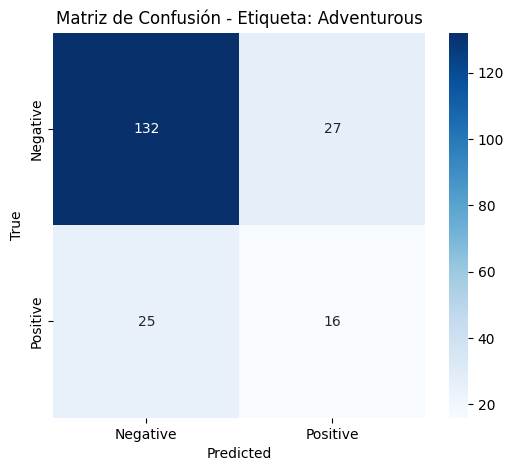

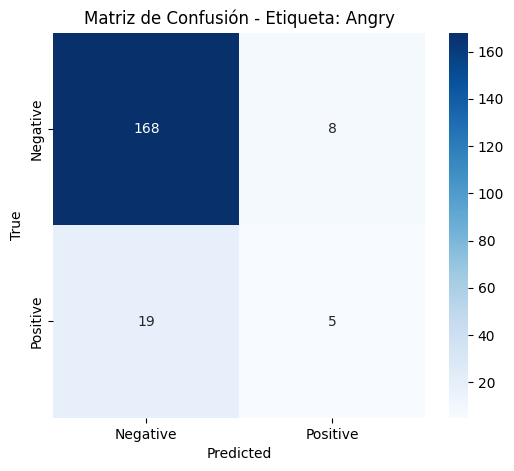

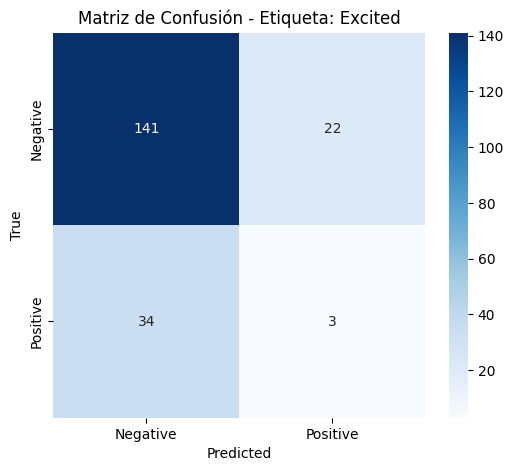

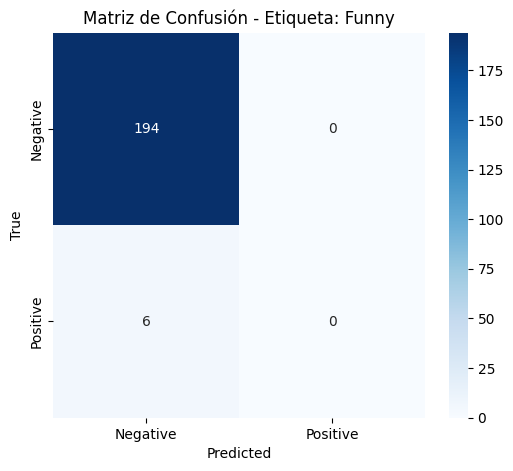

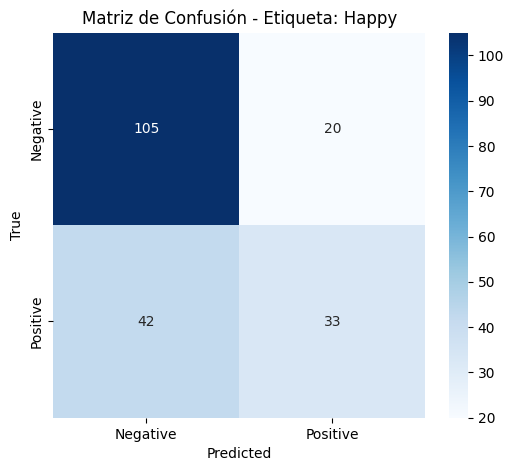

Generando Reporte de Métricas Personalizado...
        Etiqueta  Precisión    Recall  F1-Score ROC-AUC
0    Adventurous   0.372093  0.390244  0.380952    None
1          Angry   0.384615  0.208333  0.270270    None
2        Excited   0.120000  0.081081  0.096774    None
3          Funny   0.000000  0.000000  0.000000    None
4          Happy   0.622642  0.440000  0.515625    None
5   Heartwarming   0.500000  0.090909  0.153846    None
6        Hopeful   0.000000  0.000000  0.000000    None
7      Inspiring   0.404255  0.644068  0.496732    None
8      Nostalgic   0.269231  0.350000  0.304348    None
9       Romantic   0.400000  0.461538  0.428571    None
10           Sad   0.388889  0.673077  0.492958    None
11        Scared   0.500000  0.166667  0.250000    None
12   Suspenseful   0.343750  0.458333  0.392857    None
Reporte de métricas guardado como 'metrics_report.csv'.
Dataset completo con predicciones guardado como 'complete_music_predictions.csv'.


In [ ]:
# Importar librerías necesarias
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Leer la muestra y el dataset completo
df_sample = pd.read_csv('sample_music_ready_for_bert.csv')
df_complete = pd.read_csv('music_ready_for_bert.csv')

# Configuración del tokenizador
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
max_len = 128

# Tokenizar la columna 'bert_input' de la muestra
encodings = tokenizer(
    df_sample['bert_input'].tolist(),
    max_length=max_len,
    padding="max_length",
    truncation=True,
    return_tensors="pt"
)

# Crear tensores para entradas y máscaras de atención
input_ids, attention_mask = encodings["input_ids"], encodings["attention_mask"]

# Binarizar las emociones (columna 'emotion')
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(df_sample['emotion'].str.split(", "))
labels_tensor = torch.tensor(labels, dtype=torch.float32)

# Dividir datos en conjuntos de entrenamiento y validación
train_inputs, val_inputs, train_masks, val_masks, train_labels, val_labels = train_test_split(
    input_ids, attention_mask, labels_tensor, test_size=0.2, random_state=42
)

# Crear DataLoaders para manejar los datos por lotes
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_dataloader = DataLoader(val_data, batch_size=batch_size)

# Modelo BERT para clasificación multietiqueta
class BertForMultilabelClassification(torch.nn.Module):
    def __init__(self, num_labels):
        super(BertForMultilabelClassification, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return torch.sigmoid(outputs.logits)

model = BertForMultilabelClassification(num_labels=len(mlb.classes_))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Configuración del optimizador y función de pérdida
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.BCELoss()

# Lista para guardar la pérdida por época
loss_values = []

# Entrenamiento del modelo
epochs = 15
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        input_ids, masks, labels = [b.to(device) for b in batch]

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=masks)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    loss_values.append(avg_loss)
    print(f"Epoch {epoch + 1}/{epochs} - Loss: {avg_loss:.4f}")

# Gráfica de la función de pérdida
plt.plot(range(1, epochs + 1), loss_values, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.grid()
plt.show()

# Validación del modelo en el conjunto de validación
model.eval()
all_preds_val = []
all_labels_val = []

with torch.no_grad():
    for batch in val_dataloader:
        input_ids, masks, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=masks)
        preds = (outputs > 0.3).int()  # Umbral de 0.3
        all_preds_val.append(preds.cpu())
        all_labels_val.append(labels.cpu())

# Concatenar resultados de validación
all_preds_val = torch.cat(all_preds_val)
all_labels_val = torch.cat(all_labels_val)

# Classification report en el conjunto de validación
print("Classification Report - Validación")
print(classification_report(all_labels_val, all_preds_val, target_names=mlb.classes_, zero_division=0))

# Tokenizar el dataset completo
encodings_complete = tokenizer(
    df_complete['bert_input'].tolist(),
    max_length=max_len,
    padding="max_length",
    truncation=True,
    return_tensors="pt"
)

# Crear DataLoader para predicción en el dataset completo
input_ids_complete = encodings_complete["input_ids"]
attention_mask_complete = encodings_complete["attention_mask"]
complete_data = TensorDataset(input_ids_complete, attention_mask_complete)
complete_dataloader = DataLoader(complete_data, batch_size=8)

# Realizar predicciones en el dataset completo
all_predictions = []
with torch.no_grad():
    for batch in complete_dataloader:
        input_ids_batch, attention_mask_batch = [b.to(device) for b in batch]
        outputs = model(input_ids_batch, attention_mask=attention_mask_batch)
        predictions = (outputs > 0.3).int()  # Umbral reducido a 0.3
        all_predictions.append(predictions.cpu())

# Concatenar todas las predicciones
all_predictions = torch.cat(all_predictions)

# Convertir predicciones a etiquetas
predicted_emotions = [
    [mlb.classes_[i] for i, val in enumerate(pred) if val == 1]
    for pred in all_predictions.numpy()
]

# Agregar predicciones al DataFrame completo
df_complete['predicted_emotions'] = ["; ".join(emotions) for emotions in predicted_emotions]

# **Matriz de Confusión Multietiqueta**
print("Generando Matriz de Confusión Multietiqueta...")
confusion_matrices = multilabel_confusion_matrix(all_labels_val.numpy(), all_preds_val.numpy())
for i, matrix in enumerate(confusion_matrices[:5]):  # Cambia el rango según necesidad
    plt.figure(figsize=(6, 5))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f'Matriz de Confusión - Etiqueta: {mlb.classes_[i]}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# **Reporte de Métricas Personalizado**
print("Generando Reporte de Métricas Personalizado...")
metrics = []
for i, label in enumerate(mlb.classes_):
    precision = precision_score(all_labels_val.numpy()[:, i], all_preds_val.numpy()[:, i], zero_division=0)
    recall = recall_score(all_labels_val.numpy()[:, i], all_preds_val.numpy()[:, i], zero_division=0)
    f1 = f1_score(all_labels_val.numpy()[:, i], all_preds_val.numpy()[:, i], zero_division=0)
    try:
        auc = roc_auc_score(all_labels_val.numpy()[:, i], all_predictions.numpy()[:, i])
    except ValueError:
        auc = None
    metrics.append((label, precision, recall, f1, auc))

# Crear DataFrame para visualizar las métricas
df_metrics = pd.DataFrame(metrics, columns=["Etiqueta", "Precisión", "Recall", "F1-Score", "ROC-AUC"])
print(df_metrics)

# Guardar el reporte en un archivo CSV
df_metrics.to_csv('metrics_report15.csv', index=False)
print("Reporte de métricas guardado como 'metrics_report.csv'.")

# Guardar el dataset completo con las predicciones
df_complete.to_csv('complete_music_predictions15.csv', index=False)
print("Dataset completo con predicciones guardado como 'complete_music_predictions.csv'.")




**epochs = 20**

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20 - Loss: 0.5133
Epoch 2/20 - Loss: 0.4109
Epoch 3/20 - Loss: 0.4019
Epoch 4/20 - Loss: 0.3936
Epoch 5/20 - Loss: 0.3782
Epoch 6/20 - Loss: 0.3573
Epoch 7/20 - Loss: 0.3334
Epoch 8/20 - Loss: 0.3063
Epoch 9/20 - Loss: 0.2832
Epoch 10/20 - Loss: 0.2600
Epoch 11/20 - Loss: 0.2414
Epoch 12/20 - Loss: 0.2201
Epoch 13/20 - Loss: 0.1998
Epoch 14/20 - Loss: 0.1832
Epoch 15/20 - Loss: 0.1646
Epoch 16/20 - Loss: 0.1515
Epoch 17/20 - Loss: 0.1360
Epoch 18/20 - Loss: 0.1240
Epoch 19/20 - Loss: 0.1123
Epoch 20/20 - Loss: 0.1026


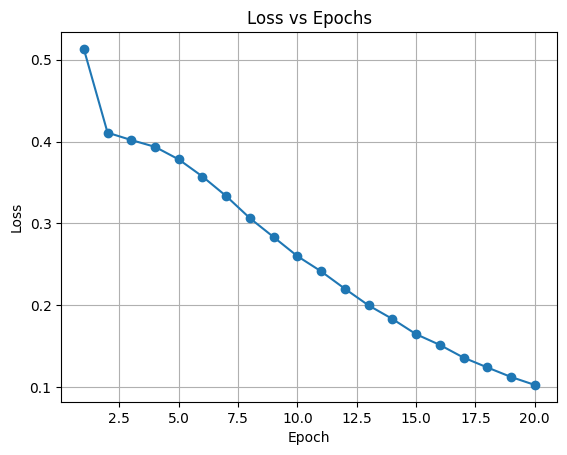

Classification Report - Validación
              precision    recall  f1-score   support

 Adventurous       0.29      0.29      0.29        41
       Angry       0.39      0.29      0.33        24
     Excited       0.26      0.24      0.25        37
       Funny       0.00      0.00      0.00         6
       Happy       0.62      0.59      0.60        75
Heartwarming       0.25      0.18      0.21        11
     Hopeful       0.17      0.21      0.19        19
   Inspiring       0.46      0.61      0.53        59
   Nostalgic       0.27      0.30      0.29        20
    Romantic       0.48      0.38      0.43        26
         Sad       0.46      0.37      0.41        52
      Scared       0.20      0.17      0.18         6
 Suspenseful       0.37      0.46      0.41        24

   micro avg       0.41      0.40      0.41       400
   macro avg       0.32      0.31      0.32       400
weighted avg       0.41      0.40      0.40       400
 samples avg       0.41      0.40      0.40  

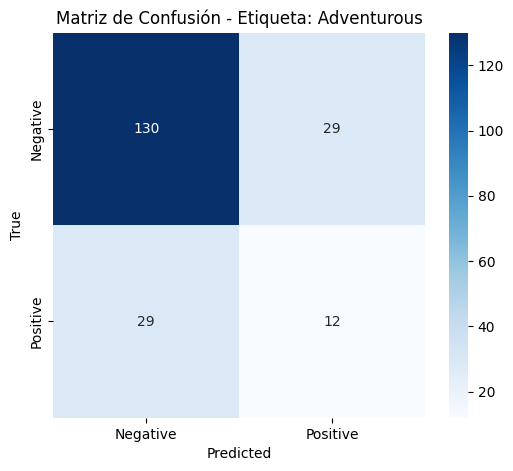

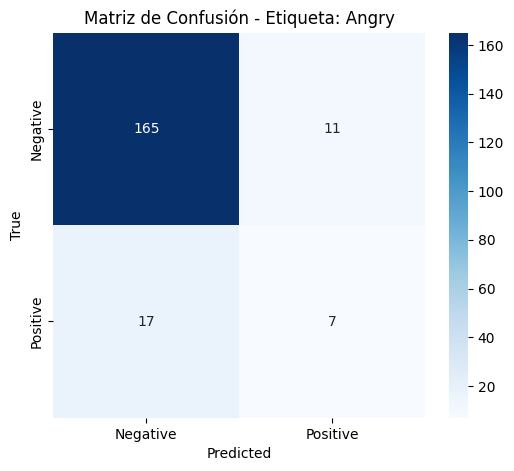

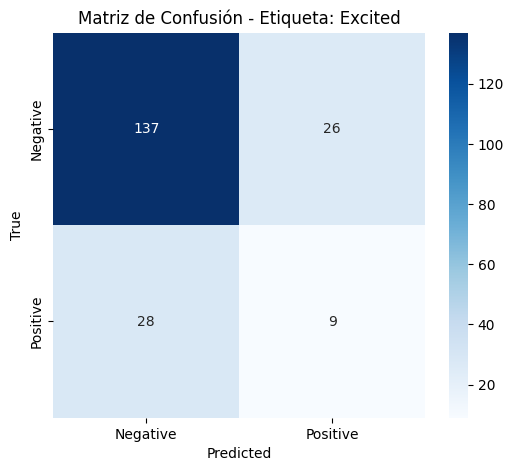

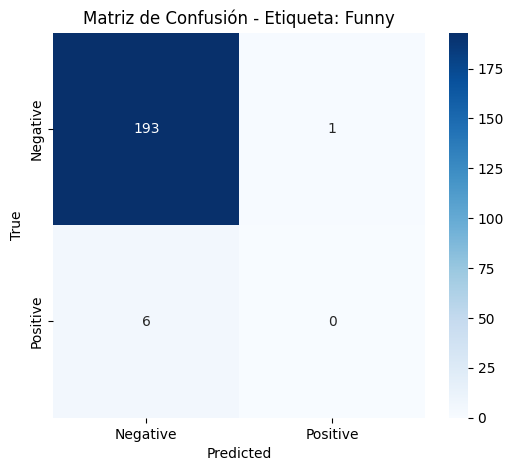

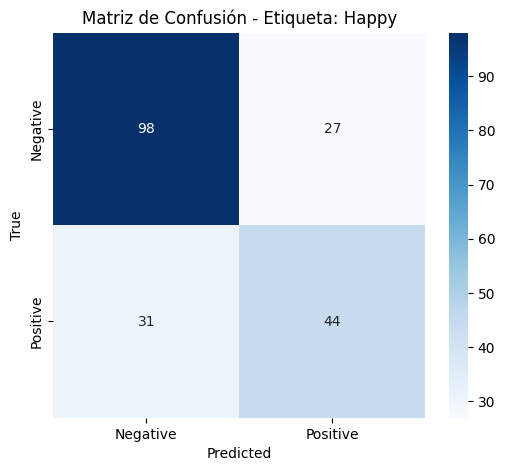

Generando Reporte de Métricas Personalizado...
        Etiqueta  Precisión    Recall  F1-Score ROC-AUC
0    Adventurous   0.292683  0.292683  0.292683    None
1          Angry   0.388889  0.291667  0.333333    None
2        Excited   0.257143  0.243243  0.250000    None
3          Funny   0.000000  0.000000  0.000000    None
4          Happy   0.619718  0.586667  0.602740    None
5   Heartwarming   0.250000  0.181818  0.210526    None
6        Hopeful   0.173913  0.210526  0.190476    None
7      Inspiring   0.461538  0.610169  0.525547    None
8      Nostalgic   0.272727  0.300000  0.285714    None
9       Romantic   0.476190  0.384615  0.425532    None
10           Sad   0.463415  0.365385  0.408602    None
11        Scared   0.200000  0.166667  0.181818    None
12   Suspenseful   0.366667  0.458333  0.407407    None
Reporte de métricas guardado como 'metrics_report.csv'.
Dataset completo con predicciones guardado como 'complete_music_predictions.csv'.


In [ ]:
# Importar librerías necesarias
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Leer la muestra y el dataset completo
df_sample = pd.read_csv('sample_music_ready_for_bert.csv')
df_complete = pd.read_csv('music_ready_for_bert.csv')

# Configuración del tokenizador
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
max_len = 128

# Tokenizar la columna 'bert_input' de la muestra
encodings = tokenizer(
    df_sample['bert_input'].tolist(),
    max_length=max_len,
    padding="max_length",
    truncation=True,
    return_tensors="pt"
)

# Crear tensores para entradas y máscaras de atención
input_ids, attention_mask = encodings["input_ids"], encodings["attention_mask"]

# Binarizar las emociones (columna 'emotion')
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(df_sample['emotion'].str.split(", "))
labels_tensor = torch.tensor(labels, dtype=torch.float32)

# Dividir datos en conjuntos de entrenamiento y validación
train_inputs, val_inputs, train_masks, val_masks, train_labels, val_labels = train_test_split(
    input_ids, attention_mask, labels_tensor, test_size=0.2, random_state=42
)

# Crear DataLoaders para manejar los datos por lotes
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_dataloader = DataLoader(val_data, batch_size=batch_size)

# Modelo BERT para clasificación multietiqueta
class BertForMultilabelClassification(torch.nn.Module):
    def __init__(self, num_labels):
        super(BertForMultilabelClassification, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return torch.sigmoid(outputs.logits)

model = BertForMultilabelClassification(num_labels=len(mlb.classes_))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Configuración del optimizador y función de pérdida
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.BCELoss()

# Lista para guardar la pérdida por época
loss_values = []

# Entrenamiento del modelo
epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        input_ids, masks, labels = [b.to(device) for b in batch]

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=masks)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    loss_values.append(avg_loss)
    print(f"Epoch {epoch + 1}/{epochs} - Loss: {avg_loss:.4f}")

# Gráfica de la función de pérdida
plt.plot(range(1, epochs + 1), loss_values, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.grid()
plt.show()

# Validación del modelo en el conjunto de validación
model.eval()
all_preds_val = []
all_labels_val = []

with torch.no_grad():
    for batch in val_dataloader:
        input_ids, masks, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=masks)
        preds = (outputs > 0.3).int()  # Umbral de 0.3
        all_preds_val.append(preds.cpu())
        all_labels_val.append(labels.cpu())

# Concatenar resultados de validación
all_preds_val = torch.cat(all_preds_val)
all_labels_val = torch.cat(all_labels_val)

# Classification report en el conjunto de validación
print("Classification Report - Validación")
print(classification_report(all_labels_val, all_preds_val, target_names=mlb.classes_, zero_division=0))

# Tokenizar el dataset completo
encodings_complete = tokenizer(
    df_complete['bert_input'].tolist(),
    max_length=max_len,
    padding="max_length",
    truncation=True,
    return_tensors="pt"
)

# Crear DataLoader para predicción en el dataset completo
input_ids_complete = encodings_complete["input_ids"]
attention_mask_complete = encodings_complete["attention_mask"]
complete_data = TensorDataset(input_ids_complete, attention_mask_complete)
complete_dataloader = DataLoader(complete_data, batch_size=8)

# Realizar predicciones en el dataset completo
all_predictions = []
with torch.no_grad():
    for batch in complete_dataloader:
        input_ids_batch, attention_mask_batch = [b.to(device) for b in batch]
        outputs = model(input_ids_batch, attention_mask=attention_mask_batch)
        predictions = (outputs > 0.3).int()  # Umbral reducido a 0.3
        all_predictions.append(predictions.cpu())

# Concatenar todas las predicciones
all_predictions = torch.cat(all_predictions)

# Convertir predicciones a etiquetas
predicted_emotions = [
    [mlb.classes_[i] for i, val in enumerate(pred) if val == 1]
    for pred in all_predictions.numpy()
]

# Agregar predicciones al DataFrame completo
df_complete['predicted_emotions'] = ["; ".join(emotions) for emotions in predicted_emotions]

# **Matriz de Confusión Multietiqueta**
print("Generando Matriz de Confusión Multietiqueta...")
confusion_matrices = multilabel_confusion_matrix(all_labels_val.numpy(), all_preds_val.numpy())
for i, matrix in enumerate(confusion_matrices[:5]):  # Cambia el rango según necesidad
    plt.figure(figsize=(6, 5))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f'Matriz de Confusión - Etiqueta: {mlb.classes_[i]}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# **Reporte de Métricas Personalizado**
print("Generando Reporte de Métricas Personalizado...")
metrics = []
for i, label in enumerate(mlb.classes_):
    precision = precision_score(all_labels_val.numpy()[:, i], all_preds_val.numpy()[:, i], zero_division=0)
    recall = recall_score(all_labels_val.numpy()[:, i], all_preds_val.numpy()[:, i], zero_division=0)
    f1 = f1_score(all_labels_val.numpy()[:, i], all_preds_val.numpy()[:, i], zero_division=0)
    try:
        auc = roc_auc_score(all_labels_val.numpy()[:, i], all_predictions.numpy()[:, i])
    except ValueError:
        auc = None
    metrics.append((label, precision, recall, f1, auc))

# Crear DataFrame para visualizar las métricas
df_metrics = pd.DataFrame(metrics, columns=["Etiqueta", "Precisión", "Recall", "F1-Score", "ROC-AUC"])
print(df_metrics)

# Guardar el reporte en un archivo CSV
df_metrics.to_csv('metrics_report20.csv', index=False)
print("Reporte de métricas guardado como 'metrics_report.csv'.")

# Guardar el dataset completo con las predicciones
df_complete.to_csv('complete_music_predictions20.csv', index=False)
print("Dataset completo con predicciones guardado como 'complete_music_predictions.csv'.")



**epochs = 25**

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/25 - Loss: 0.5065
Epoch 2/25 - Loss: 0.4100
Epoch 3/25 - Loss: 0.3975
Epoch 4/25 - Loss: 0.3892
Epoch 5/25 - Loss: 0.3709
Epoch 6/25 - Loss: 0.3522
Epoch 7/25 - Loss: 0.3314
Epoch 8/25 - Loss: 0.3084
Epoch 9/25 - Loss: 0.2871
Epoch 10/25 - Loss: 0.2618
Epoch 11/25 - Loss: 0.2420
Epoch 12/25 - Loss: 0.2207
Epoch 13/25 - Loss: 0.2011
Epoch 14/25 - Loss: 0.1858
Epoch 15/25 - Loss: 0.1718
Epoch 16/25 - Loss: 0.1563
Epoch 17/25 - Loss: 0.1445
Epoch 18/25 - Loss: 0.1305
Epoch 19/25 - Loss: 0.1199
Epoch 20/25 - Loss: 0.1106
Epoch 21/25 - Loss: 0.1018
Epoch 22/25 - Loss: 0.0935
Epoch 23/25 - Loss: 0.0884
Epoch 24/25 - Loss: 0.0810
Epoch 25/25 - Loss: 0.0746


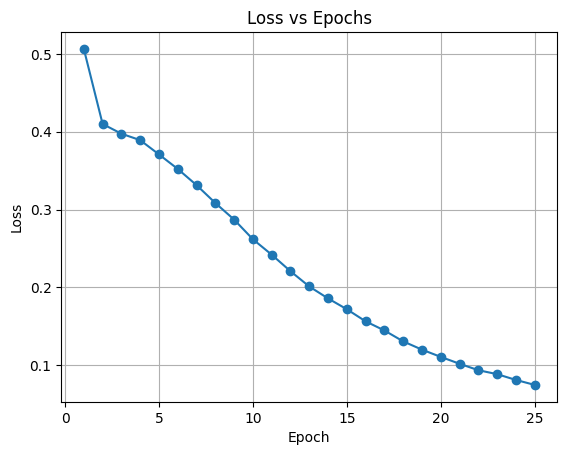

Classification Report - Validación
              precision    recall  f1-score   support

 Adventurous       0.34      0.29      0.32        41
       Angry       0.42      0.42      0.42        24
     Excited       0.24      0.30      0.27        37
       Funny       0.50      0.17      0.25         6
       Happy       0.59      0.45      0.51        75
Heartwarming       0.20      0.09      0.12        11
     Hopeful       0.07      0.05      0.06        19
   Inspiring       0.44      0.61      0.51        59
   Nostalgic       0.35      0.35      0.35        20
    Romantic       0.41      0.50      0.45        26
         Sad       0.43      0.42      0.43        52
      Scared       0.20      0.33      0.25         6
 Suspenseful       0.31      0.46      0.37        24

   micro avg       0.39      0.40      0.40       400
   macro avg       0.35      0.34      0.33       400
weighted avg       0.40      0.40      0.39       400
 samples avg       0.39      0.40      0.39  

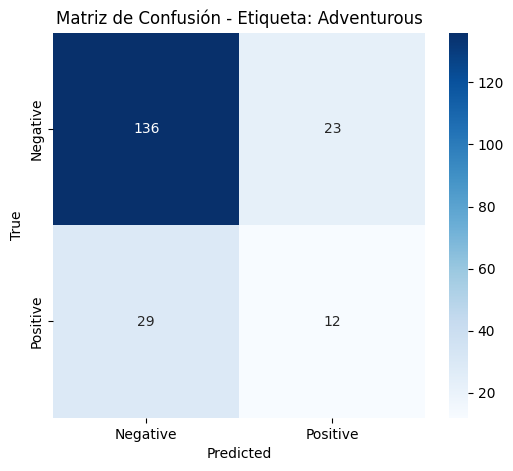

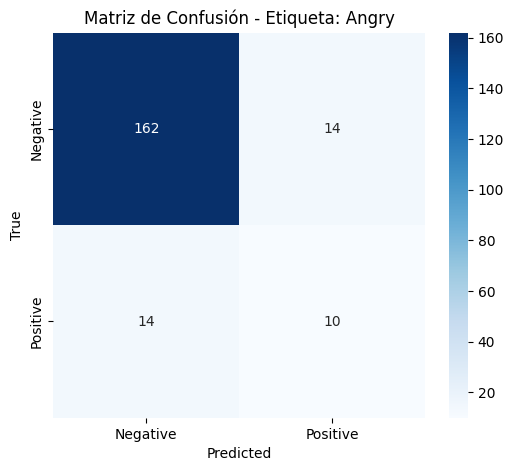

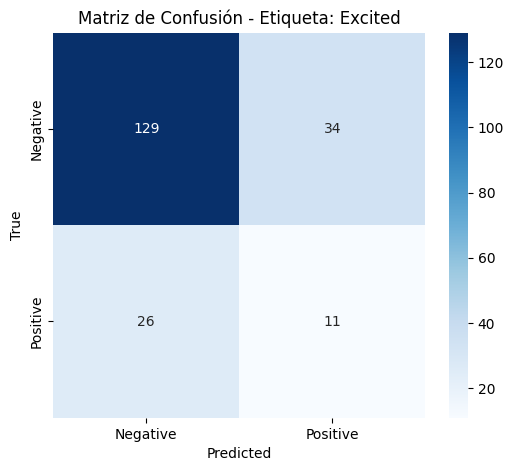

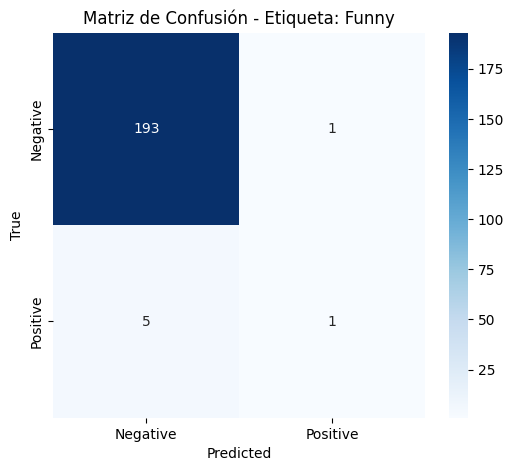

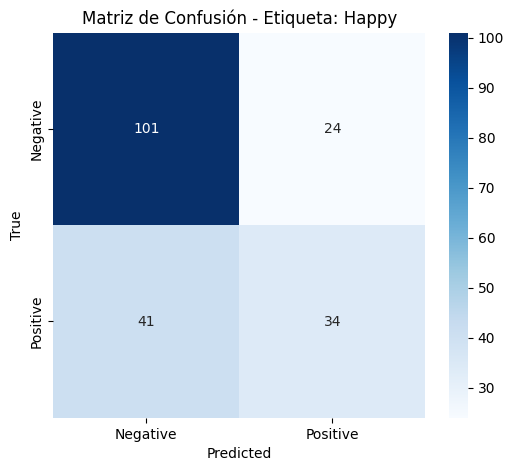

Generando Reporte de Métricas Personalizado...
        Etiqueta  Precisión    Recall  F1-Score ROC-AUC
0    Adventurous   0.342857  0.292683  0.315789    None
1          Angry   0.416667  0.416667  0.416667    None
2        Excited   0.244444  0.297297  0.268293    None
3          Funny   0.500000  0.166667  0.250000    None
4          Happy   0.586207  0.453333  0.511278    None
5   Heartwarming   0.200000  0.090909  0.125000    None
6        Hopeful   0.071429  0.052632  0.060606    None
7      Inspiring   0.444444  0.610169  0.514286    None
8      Nostalgic   0.350000  0.350000  0.350000    None
9       Romantic   0.406250  0.500000  0.448276    None
10           Sad   0.431373  0.423077  0.427184    None
11        Scared   0.200000  0.333333  0.250000    None
12   Suspenseful   0.305556  0.458333  0.366667    None
Reporte de métricas guardado como 'metrics_report.csv'.
Dataset completo con predicciones guardado como 'complete_music_predictions.csv'.


In [ ]:
# Importar librerías necesarias
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Leer la muestra y el dataset completo
df_sample = pd.read_csv('sample_music_ready_for_bert.csv')
df_complete = pd.read_csv('music_ready_for_bert.csv')

# Configuración del tokenizador
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
max_len = 128

# Tokenizar la columna 'bert_input' de la muestra
encodings = tokenizer(
    df_sample['bert_input'].tolist(),
    max_length=max_len,
    padding="max_length",
    truncation=True,
    return_tensors="pt"
)

# Crear tensores para entradas y máscaras de atención
input_ids, attention_mask = encodings["input_ids"], encodings["attention_mask"]

# Binarizar las emociones (columna 'emotion')
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(df_sample['emotion'].str.split(", "))
labels_tensor = torch.tensor(labels, dtype=torch.float32)

# Dividir datos en conjuntos de entrenamiento y validación
train_inputs, val_inputs, train_masks, val_masks, train_labels, val_labels = train_test_split(
    input_ids, attention_mask, labels_tensor, test_size=0.2, random_state=42
)

# Crear DataLoaders para manejar los datos por lotes
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_dataloader = DataLoader(val_data, batch_size=batch_size)

# Modelo BERT para clasificación multietiqueta
class BertForMultilabelClassification(torch.nn.Module):
    def __init__(self, num_labels):
        super(BertForMultilabelClassification, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return torch.sigmoid(outputs.logits)

model = BertForMultilabelClassification(num_labels=len(mlb.classes_))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Configuración del optimizador y función de pérdida
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.BCELoss()

# Lista para guardar la pérdida por época
loss_values = []

# Entrenamiento del modelo
epochs = 25
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        input_ids, masks, labels = [b.to(device) for b in batch]

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=masks)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    loss_values.append(avg_loss)
    print(f"Epoch {epoch + 1}/{epochs} - Loss: {avg_loss:.4f}")

# Gráfica de la función de pérdida
plt.plot(range(1, epochs + 1), loss_values, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.grid()
plt.show()

# Validación del modelo en el conjunto de validación
model.eval()
all_preds_val = []
all_labels_val = []

with torch.no_grad():
    for batch in val_dataloader:
        input_ids, masks, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=masks)
        preds = (outputs > 0.3).int()  # Umbral de 0.3
        all_preds_val.append(preds.cpu())
        all_labels_val.append(labels.cpu())

# Concatenar resultados de validación
all_preds_val = torch.cat(all_preds_val)
all_labels_val = torch.cat(all_labels_val)

# Classification report en el conjunto de validación
print("Classification Report - Validación")
print(classification_report(all_labels_val, all_preds_val, target_names=mlb.classes_, zero_division=0))

# Tokenizar el dataset completo
encodings_complete = tokenizer(
    df_complete['bert_input'].tolist(),
    max_length=max_len,
    padding="max_length",
    truncation=True,
    return_tensors="pt"
)

# Crear DataLoader para predicción en el dataset completo
input_ids_complete = encodings_complete["input_ids"]
attention_mask_complete = encodings_complete["attention_mask"]
complete_data = TensorDataset(input_ids_complete, attention_mask_complete)
complete_dataloader = DataLoader(complete_data, batch_size=8)

# Realizar predicciones en el dataset completo
all_predictions = []
with torch.no_grad():
    for batch in complete_dataloader:
        input_ids_batch, attention_mask_batch = [b.to(device) for b in batch]
        outputs = model(input_ids_batch, attention_mask=attention_mask_batch)
        predictions = (outputs > 0.3).int()  # Umbral reducido a 0.3
        all_predictions.append(predictions.cpu())

# Concatenar todas las predicciones
all_predictions = torch.cat(all_predictions)

# Convertir predicciones a etiquetas
predicted_emotions = [
    [mlb.classes_[i] for i, val in enumerate(pred) if val == 1]
    for pred in all_predictions.numpy()
]

# Agregar predicciones al DataFrame completo
df_complete['predicted_emotions'] = ["; ".join(emotions) for emotions in predicted_emotions]

# **Matriz de Confusión Multietiqueta**
print("Generando Matriz de Confusión Multietiqueta...")
confusion_matrices = multilabel_confusion_matrix(all_labels_val.numpy(), all_preds_val.numpy())
for i, matrix in enumerate(confusion_matrices[:5]):  # Cambia el rango según necesidad
    plt.figure(figsize=(6, 5))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f'Matriz de Confusión - Etiqueta: {mlb.classes_[i]}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# **Reporte de Métricas Personalizado**
print("Generando Reporte de Métricas Personalizado...")
metrics = []
for i, label in enumerate(mlb.classes_):
    precision = precision_score(all_labels_val.numpy()[:, i], all_preds_val.numpy()[:, i], zero_division=0)
    recall = recall_score(all_labels_val.numpy()[:, i], all_preds_val.numpy()[:, i], zero_division=0)
    f1 = f1_score(all_labels_val.numpy()[:, i], all_preds_val.numpy()[:, i], zero_division=0)
    try:
        auc = roc_auc_score(all_labels_val.numpy()[:, i], all_predictions.numpy()[:, i])
    except ValueError:
        auc = None
    metrics.append((label, precision, recall, f1, auc))

# Crear DataFrame para visualizar las métricas
df_metrics = pd.DataFrame(metrics, columns=["Etiqueta", "Precisión", "Recall", "F1-Score", "ROC-AUC"])
print(df_metrics)

# Guardar el reporte en un archivo CSV
df_metrics.to_csv('metrics_report25.csv', index=False)
print("Reporte de métricas guardado como 'metrics_report.csv'.")

# Guardar el dataset completo con las predicciones
df_complete.to_csv('complete_music_predictions25.csv', index=False)
print("Dataset completo con predicciones guardado como 'complete_music_predictions.csv'.")



# Modelo BERT seleccionado

Después de realizar las pruebas el mejor modelo es el de 20 epochs

Nuevamente se corre el código con 20 etapas, dado que el dataset cambio al agregar la columna de estandarización del genero

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20 - Loss: 0.5006
Epoch 2/20 - Loss: 0.4085
Epoch 3/20 - Loss: 0.3991
Epoch 4/20 - Loss: 0.3891
Epoch 5/20 - Loss: 0.3724
Epoch 6/20 - Loss: 0.3487
Epoch 7/20 - Loss: 0.3195
Epoch 8/20 - Loss: 0.2906
Epoch 9/20 - Loss: 0.2622
Epoch 10/20 - Loss: 0.2345
Epoch 11/20 - Loss: 0.2120
Epoch 12/20 - Loss: 0.1911
Epoch 13/20 - Loss: 0.1723
Epoch 14/20 - Loss: 0.1559
Epoch 15/20 - Loss: 0.1397
Epoch 16/20 - Loss: 0.1285
Epoch 17/20 - Loss: 0.1184
Epoch 18/20 - Loss: 0.1076
Epoch 19/20 - Loss: 0.0987
Epoch 20/20 - Loss: 0.0916


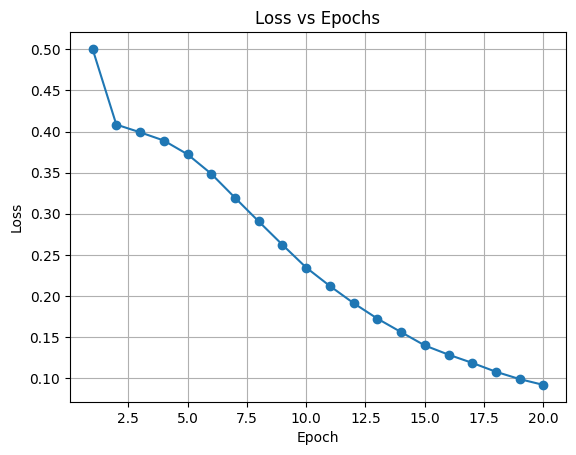

Classification Report - Validación
              precision    recall  f1-score   support

 Adventurous       0.39      0.44      0.41        41
       Angry       0.26      0.38      0.31        24
     Excited       0.27      0.35      0.30        37
       Funny       0.00      0.00      0.00         6
       Happy       0.57      0.41      0.48        75
Heartwarming       0.22      0.18      0.20        11
     Hopeful       0.19      0.26      0.22        19
   Inspiring       0.46      0.42      0.44        59
   Nostalgic       0.20      0.45      0.28        20
    Romantic       0.45      0.38      0.42        26
         Sad       0.40      0.40      0.40        52
      Scared       0.25      0.17      0.20         6
 Suspenseful       0.39      0.46      0.42        24

   micro avg       0.37      0.39      0.38       400
   macro avg       0.31      0.33      0.31       400
weighted avg       0.39      0.39      0.38       400
 samples avg       0.38      0.39      0.37  

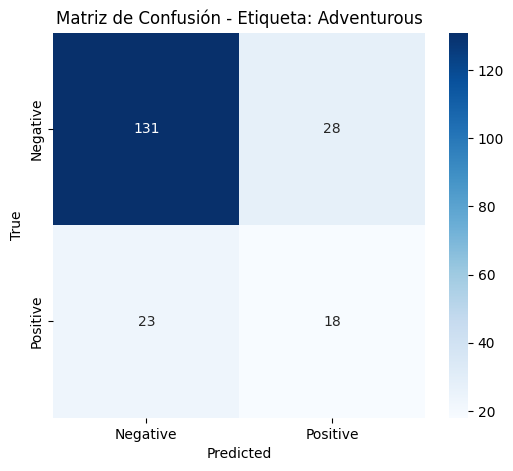

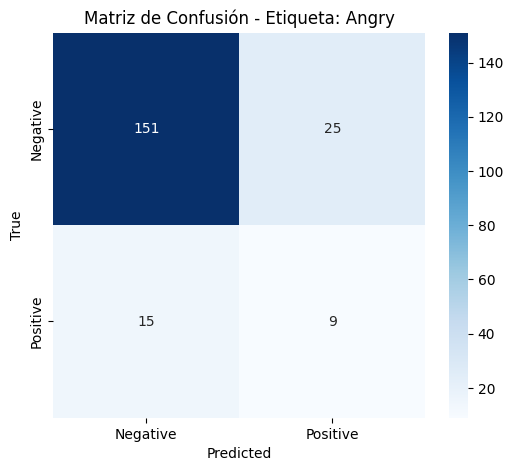

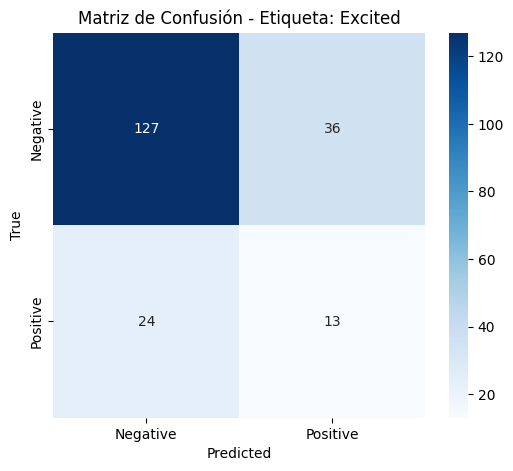

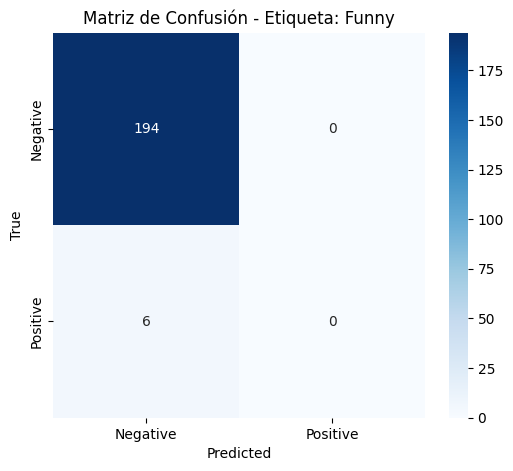

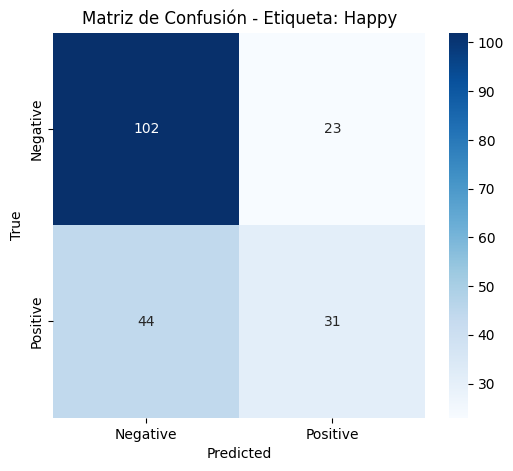

Generando Reporte de Métricas Personalizado...
        Etiqueta  Precisión    Recall  F1-Score ROC-AUC
0    Adventurous   0.391304  0.439024  0.413793    None
1          Angry   0.264706  0.375000  0.310345    None
2        Excited   0.265306  0.351351  0.302326    None
3          Funny   0.000000  0.000000  0.000000    None
4          Happy   0.574074  0.413333  0.480620    None
5   Heartwarming   0.222222  0.181818  0.200000    None
6        Hopeful   0.192308  0.263158  0.222222    None
7      Inspiring   0.462963  0.423729  0.442478    None
8      Nostalgic   0.204545  0.450000  0.281250    None
9       Romantic   0.454545  0.384615  0.416667    None
10           Sad   0.396226  0.403846  0.400000    None
11        Scared   0.250000  0.166667  0.200000    None
12   Suspenseful   0.392857  0.458333  0.423077    None
Reporte de métricas guardado como 'metrics_report.csv'.
Dataset completo con predicciones guardado como 'complete_music_predictions.csv'.


In [2]:
# Importar librerías necesarias
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Leer la muestra y el dataset completo
df_sample = pd.read_csv('sample_music_ready_for_bert.csv')
df_complete = pd.read_csv('music_ready_for_bert.csv')

# Configuración del tokenizador
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
max_len = 128

# Tokenizar la columna 'bert_input' de la muestra
encodings = tokenizer(
    df_sample['bert_input'].tolist(),
    max_length=max_len,
    padding="max_length",
    truncation=True,
    return_tensors="pt"
)

# Crear tensores para entradas y máscaras de atención
input_ids, attention_mask = encodings["input_ids"], encodings["attention_mask"]

# Binarizar las emociones (columna 'emotion')
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(df_sample['emotion'].str.split(", "))
labels_tensor = torch.tensor(labels, dtype=torch.float32)

# Dividir datos en conjuntos de entrenamiento y validación
train_inputs, val_inputs, train_masks, val_masks, train_labels, val_labels = train_test_split(
    input_ids, attention_mask, labels_tensor, test_size=0.2, random_state=42
)

# Crear DataLoaders para manejar los datos por lotes
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_dataloader = DataLoader(val_data, batch_size=batch_size)

# Modelo BERT para clasificación multietiqueta
class BertForMultilabelClassification(torch.nn.Module):
    def __init__(self, num_labels):
        super(BertForMultilabelClassification, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return torch.sigmoid(outputs.logits)

model = BertForMultilabelClassification(num_labels=len(mlb.classes_))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Configuración del optimizador y función de pérdida
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.BCELoss()

# Lista para guardar la pérdida por época
loss_values = []

# Entrenamiento del modelo
epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        input_ids, masks, labels = [b.to(device) for b in batch]

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=masks)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    loss_values.append(avg_loss)
    print(f"Epoch {epoch + 1}/{epochs} - Loss: {avg_loss:.4f}")

# Gráfica de la función de pérdida
plt.plot(range(1, epochs + 1), loss_values, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.grid()
plt.show()

# Validación del modelo en el conjunto de validación
model.eval()
all_preds_val = []
all_labels_val = []

with torch.no_grad():
    for batch in val_dataloader:
        input_ids, masks, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=masks)
        preds = (outputs > 0.3).int()  # Umbral de 0.3
        all_preds_val.append(preds.cpu())
        all_labels_val.append(labels.cpu())

# Concatenar resultados de validación
all_preds_val = torch.cat(all_preds_val)
all_labels_val = torch.cat(all_labels_val)

# Classification report en el conjunto de validación
print("Classification Report - Validación")
print(classification_report(all_labels_val, all_preds_val, target_names=mlb.classes_, zero_division=0))

# Tokenizar el dataset completo
encodings_complete = tokenizer(
    df_complete['bert_input'].tolist(),
    max_length=max_len,
    padding="max_length",
    truncation=True,
    return_tensors="pt"
)

# Crear DataLoader para predicción en el dataset completo
input_ids_complete = encodings_complete["input_ids"]
attention_mask_complete = encodings_complete["attention_mask"]
complete_data = TensorDataset(input_ids_complete, attention_mask_complete)
complete_dataloader = DataLoader(complete_data, batch_size=8)

# Realizar predicciones en el dataset completo
all_predictions = []
with torch.no_grad():
    for batch in complete_dataloader:
        input_ids_batch, attention_mask_batch = [b.to(device) for b in batch]
        outputs = model(input_ids_batch, attention_mask=attention_mask_batch)
        predictions = (outputs > 0.3).int()  # Umbral reducido a 0.3
        all_predictions.append(predictions.cpu())

# Concatenar todas las predicciones
all_predictions = torch.cat(all_predictions)

# Convertir predicciones a etiquetas
predicted_emotions = [
    [mlb.classes_[i] for i, val in enumerate(pred) if val == 1]
    for pred in all_predictions.numpy()
]

# Agregar predicciones al DataFrame completo
df_complete['predicted_emotions'] = ["; ".join(emotions) for emotions in predicted_emotions]

# **Matriz de Confusión Multietiqueta**
print("Generando Matriz de Confusión Multietiqueta...")
confusion_matrices = multilabel_confusion_matrix(all_labels_val.numpy(), all_preds_val.numpy())
for i, matrix in enumerate(confusion_matrices[:5]):  # Cambia el rango según necesidad
    plt.figure(figsize=(6, 5))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f'Matriz de Confusión - Etiqueta: {mlb.classes_[i]}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# **Reporte de Métricas Personalizado**
print("Generando Reporte de Métricas Personalizado...")
metrics = []
for i, label in enumerate(mlb.classes_):
    precision = precision_score(all_labels_val.numpy()[:, i], all_preds_val.numpy()[:, i], zero_division=0)
    recall = recall_score(all_labels_val.numpy()[:, i], all_preds_val.numpy()[:, i], zero_division=0)
    f1 = f1_score(all_labels_val.numpy()[:, i], all_preds_val.numpy()[:, i], zero_division=0)
    try:
        auc = roc_auc_score(all_labels_val.numpy()[:, i], all_predictions.numpy()[:, i])
    except ValueError:
        auc = None
    metrics.append((label, precision, recall, f1, auc))

# Crear DataFrame para visualizar las métricas
df_metrics = pd.DataFrame(metrics, columns=["Etiqueta", "Precisión", "Recall", "F1-Score", "ROC-AUC"])
print(df_metrics)

# Guardar el reporte en un archivo CSV
df_metrics.to_csv('metrics_report_final_music.csv', index=False)
print("Reporte de métricas guardado como 'metrics_report.csv'.")

# Guardar el dataset completo con las predicciones
df_complete.to_csv('music_predictions_final_.csv', index=False)
print("Dataset completo con predicciones guardado como 'complete_music_predictions.csv'.")

**Matriz de confusión global**

<Figure size 800x600 with 0 Axes>

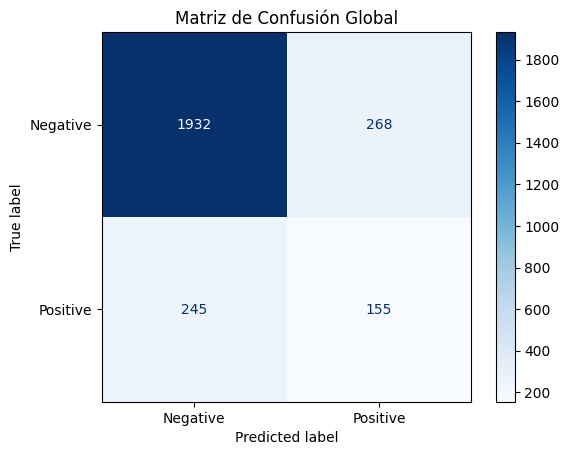

In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convertir los valores reales y predicciones a arreglos binarios globales
y_true_global = all_labels_val.numpy().ravel()
y_pred_global = all_preds_val.numpy().ravel()

# Generar la matriz de confusión global
conf_matrix_global = confusion_matrix(y_true_global, y_pred_global)

# Visualizar la matriz de confusión global
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(conf_matrix_global, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Matriz de Confusión Global")
plt.show()


In [4]:
import numpy as np
import pandas as pd

# Obtener los valores de la matriz de confusión global
tn, fp, fn, tp = conf_matrix_global.ravel()

# Crear un resumen de métricas a partir de la matriz de confusión
metrics_summary = {
    "True Negatives (TN)": tn,
    "False Positives (FP)": fp,
    "False Negatives (FN)": fn,
    "True Positives (TP)": tp,
    "Accuracy": (tp + tn) / (tp + tn + fp + fn),
    "Precision": tp / (tp + fp) if (tp + fp) > 0 else 0,
    "Recall": tp / (tp + fn) if (tp + fn) > 0 else 0,
    "F1-Score": (2 * tp / (2 * tp + fp + fn)) if (2 * tp + fp + fn) > 0 else 0
}

# Convertir el resumen a un DataFrame para facilitar el guardado
df_metrics_summary = pd.DataFrame([metrics_summary])

# Guardar el resumen en un archivo CSV
df_metrics_summary.to_csv("global_confusion_metrics_summary.csv", index=False)
print("Resumen de métricas guardado como 'global_confusion_metrics_summary.csv'.")


Resumen de métricas guardado como 'global_confusion_metrics_summary.csv'.


In [ ]:
Mostrar siempre los detalles

Copiar código
import pandas as pd

# Cargar el archivo proporcionado por el usuario
file_path = '/mnt/data/global_confusion_metrics_summary.csv'
confusion_metrics_summary = pd.read_csv(file_path)

# Visualizar los datos para el análisis
confusion_metrics_summary.head()

**Análisis de los Resultados para el Dataset de Música con 20 Épocas:**

Pérdida Progresiva:

La pérdida inicial comenzó en 0.5006 y se redujo progresivamente hasta 0.0916 en la última época.
Esto indica un buen aprendizaje del modelo sin signos evidentes de sobreajuste.
Métricas del Classification Report - Validación:

F1-Score Promedio (macro): 0.31
F1-Score Promedio (micro): 0.38
Etiquetas con mejor desempeño:
Adventurous (F1: 0.41)
Happy (F1: 0.48)
Suspenseful (F1: 0.42)
Etiquetas con peor desempeño:
Funny (F1: 0.00)
Heartwarming (F1: 0.20)
Scared (F1: 0.20)
Observaciones Clave:

Etiquetas Balanceadas: Las etiquetas con mayor representación (como Adventurous, Happy) muestran un mejor desempeño, mientras que etiquetas menos frecuentes como Funny tienen un desempeño pobre.
Recall Alto para Algunas Etiquetas: Por ejemplo, Nostalgic tiene un recall de 0.45, indicando que el modelo es bueno identificando esta etiqueta pero menos preciso.
Reporte de Métricas Personalizado:

El modelo tiene desempeño balanceado en etiquetas clave como Adventurous, Suspenseful, y Romantic.
Algunas etiquetas como Hopeful y Funny requieren ajustes adicionales, posiblemente por la baja representación en la muestra de entrenamiento.
